In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import image
import random as rn

import numpy as np 
import os 
import pandas as pd 
import cv2 as cv2
import zipfile

from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D, LeakyReLU,
                          Conv2DTranspose, Activation,Concatenate, GlobalAveragePooling2D)
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
    
SEED = 1234
np.random.seed(SEED)
rn.seed(SEED)

In [2]:
out_path    =   ("./miniddsm2")
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
with zipfile.ZipFile("../input/data-pre-processing/miniddsm2.zip", 'r') as zip_ref:
    zip_ref.extractall("./miniddsm2")

In [3]:
img_list = []
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if filename.endswith(".png") and "Mask" not in filename:
            img_list.append(os.path.join(dirname, filename))

In [4]:
import csv
import matplotlib.image as mpimg

with open('./data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_path", "label"])
    for img_name in img_list:
        if "Benign" in img_name:
            writer.writerow([img_name, "Benign"])
        if "Cancer" in img_name:
            writer.writerow([img_name, "Cancer"])
        if "Normal" in img_name:
            writer.writerow([img_name, "Normal"])

In [5]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset as dataframe
df = pd.read_csv("./data.csv")
target = df["label"]
df

,image_path,label
0,./miniddsm2/Normal/A_1977_1.RIGHT_MLO.png,Normal
1,./miniddsm2/Normal/D_4540_1.LEFT_MLO.png,Normal
2,./miniddsm2/Normal/A_0496_1.LEFT_CC.png,Normal
3,./miniddsm2/Normal/A_0434_1.RIGHT_MLO.png,Normal
4,./miniddsm2/Normal/D_4548_1.LEFT_CC.png,Normal
...,...,...
7803,./miniddsm2/Benign/A_1936_1.LEFT_CC.png,Benign
7804,./miniddsm2/Benign/A_1811_1.RIGHT_CC.png,Benign
7805,./miniddsm2/Benign/A_1882_1.LEFT_MLO.png,Benign
7806,./miniddsm2/Benign/A_1938_1.RIGHT_MLO.png,Benign


uint8


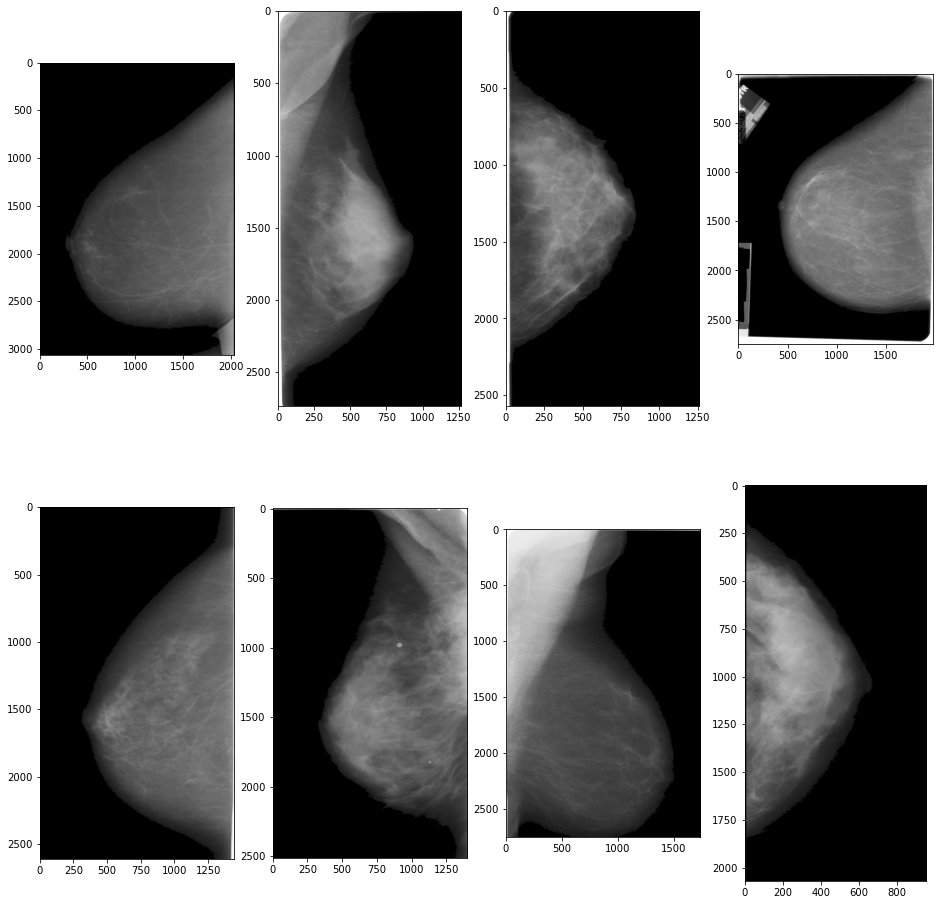

In [6]:
# Show thr first 8 images

fig = plt.gcf()
fig.set_size_inches(4 * 4, 4 * 4)

for i, img_path in enumerate(df["image_path"][10:18]):
    sp = plt.subplot(2,4, i + 1)

    img_1 = cv2.imread(img_path)
    plt.imshow(img_1, cmap='gray')
    
print(img_1.dtype)

In [7]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df, random_state=SEED)
df_shuffled

,image_path,label
2815,./miniddsm2/Cancer/C_0130_1.RIGHT_MLO.png,Cancer
2451,./miniddsm2/Cancer/A_1533_1.LEFT_MLO.png,Cancer
7561,./miniddsm2/Benign/C_0393_1.LEFT_CC.png,Benign
4116,./miniddsm2/Cancer/B_3021_1.LEFT_CC.png,Cancer
3718,./miniddsm2/Cancer/B_3001_1.RIGHT_CC.png,Cancer
...,...,...
3276,./miniddsm2/Cancer/C_0171_1.LEFT_CC.png,Cancer
7221,./miniddsm2/Benign/D_4076_1.LEFT_CC.png,Benign
1318,./miniddsm2/Normal/A_0216_1.LEFT_MLO.png,Normal
723,./miniddsm2/Normal/A_0358_1.RIGHT_CC.png,Normal


(2684, 2716, 2408)


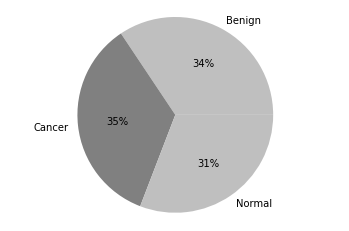

In [8]:
### Distribution of data in classes ###
labels = ('Benign', 'Cancer', 'Normal')
counts = (
    np.count_nonzero(df["label"] == 'Benign'),
    np.count_nonzero(df["label"] == 'Cancer'),
    np.count_nonzero(df["label"] == 'Normal'))

print(counts)

plt.pie(counts, labels=labels, colors=('#BFBFBF', '#808080'), autopct='%1.f%%')
plt.axis('equal')
plt.show()

In [9]:
### Preparing image generators with rescaling, resizing ###
batch_size   = 16
v_batch_size = 16
input_size   = (224, 224)

# Load images using Keras ImageDataGenerator

datagen = ImageDataGenerator(
                rescale = 1/255,
                validation_split=0.20, 
)

In [10]:
train_generator = datagen.flow_from_dataframe(
    dataframe=df_shuffled,
    x_col='image_path',
    y_col='label',
    subset="training",
    batch_size=batch_size,
    seed=SEED,
    shuffle=True,
    class_mode='categorical',
    target_size=input_size,
)
print('Train generator created')

validation_generator = datagen.flow_from_dataframe(
    dataframe = df_shuffled,
    x_col='image_path',
    y_col='label',
    subset="validation",
    batch_size=v_batch_size,
    seed=SEED,
    shuffle=True,
    class_mode='categorical',
    target_size=input_size,

)
print('Validation generator created')


Found 6247 validated image filenames belonging to 3 classes.
Train generator created
Found 1561 validated image filenames belonging to 3 classes.
Validation generator created


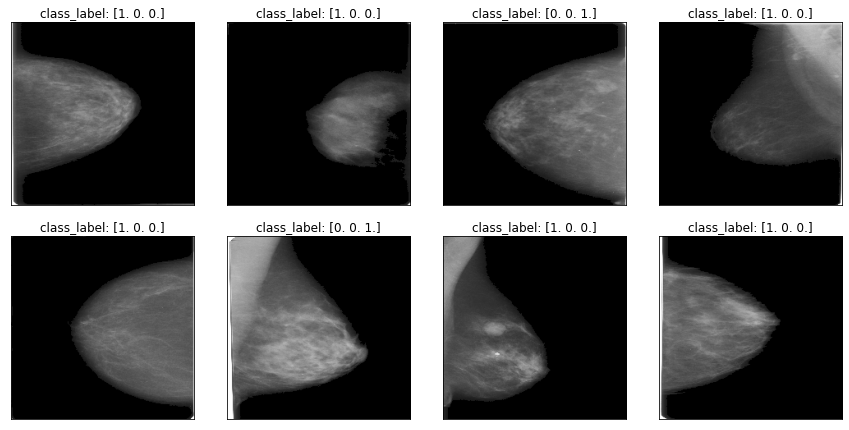

In [11]:
x, y = train_generator.next()
import matplotlib.pyplot as plt
fig = plt.figure(1,figsize=(12,12))
for i in range(8,16):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    x[i] = x[i][:,:,::-1]
    plt.imshow(x[i], cmap="gist_gray", interpolation=None)
    plt.title("class_label: {}".format(y[i]))
    plt.xticks([])
    plt.yticks([])

In [12]:
import math
print(train_generator.n)
print(validation_generator.n)

# Number of train and validation steps
train_steps= train_generator.n // batch_size
valid_steps= validation_generator.n // batch_size
lr_decay = (1./0.80 - 1) / train_steps

print(train_steps)
print(valid_steps)
print("lr_decay:" ,lr_decay)

6247
1561
390
97
lr_decay: 0.000641025641025641


# Feature extraction

#### In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.[](http://)

In [13]:
# Re-loads the MobileNet model without the top or FC layers
base_model = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224,224,3))

# Freeze the convolutional base
base_model.trainable = False
    
for (i,layer) in enumerate(base_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17227776/17225924 [==============================] - 1s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization F

In [14]:
from keras.models import Model

def addTopModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model) 
    top_model = Dropout(0.3)(top_model)    
    top_model = Dense(1024,activation='relu')(top_model) 
    top_model = Dropout(0.5)(top_model)  
    top_model = Dense(num_classes, activation = "softmax")(top_model)

    return top_model

In [15]:
num_classes = 3

FC_Head = addTopModel(base_model, num_classes)

model = Model(inputs=base_model.input, outputs=FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [16]:
### Defining callbacks ###
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_lr=0.0001)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    mode='auto')

filepath="model_{epoch:02d}_{val_accuracy:.2f}.hdf5"

model_checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')


callbacks = [reduce_lr, early_stopping, model_checkpoint]


In [17]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001, decay =lr_decay),
              metrics = ['accuracy'])

In [18]:
len(model.trainable_variables)

6

In [19]:
loss0, accuracy0 = model.evaluate(validation_generator, steps=valid_steps, verbose=1)

97/97 [==============================] - 73s 721ms/step - loss: 1.3608 - accuracy: 0.3047


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.35
initial accuracy: 0.31


In [21]:
from keras.models import load_model

initial_epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    epochs = initial_epochs,
    shuffle=True,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // batch_size)


Epoch 1/20
390/390 [==============================] - 366s 935ms/step - loss: 0.9995 - accuracy: 0.4975 - val_loss: 0.8658 - val_accuracy: 0.5651

Epoch 00001: val_accuracy improved from -inf to 0.56508, saving model to model_01_0.57.hdf5
Epoch 2/20
390/390 [==============================] - 353s 906ms/step - loss: 0.8540 - accuracy: 0.5591 - val_loss: 0.8421 - val_accuracy: 0.5741

Epoch 00002: val_accuracy improved from 0.56508 to 0.57410, saving model to model_02_0.57.hdf5
Epoch 3/20
390/390 [==============================] - 349s 894ms/step - loss: 0.8208 - accuracy: 0.5786 - val_loss: 0.8509 - val_accuracy: 0.5780

Epoch 00003: val_accuracy improved from 0.57410 to 0.57796, saving model to model_03_0.58.hdf5
Epoch 4/20
390/390 [==============================] - 351s 901ms/step - loss: 0.7970 - accuracy: 0.6025 - val_loss: 0.8083 - val_accuracy: 0.6018

Epoch 00004: val_accuracy improved from 0.57796 to 0.60180, saving model to model_04_0.60.hdf5
Epoch 5/20
390/390 [===============

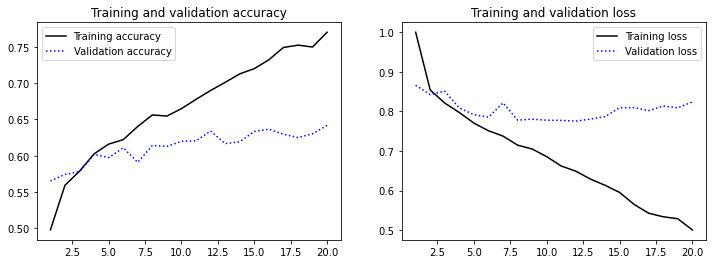

In [22]:
### Accuracy and loss plots ### 
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']



epochs = [n + 1 for n in range(len(acc))]
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'k', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss, 'k', label='Training loss')
plt.plot(epochs, val_loss, 'b:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning
## Un-freeze the top layers of the model


In [23]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  86


In [24]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001/10),
              metrics = ['accuracy'])

In [25]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [26]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine  = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    epochs = total_epochs,
    initial_epoch=history.epoch[-1],
    shuffle=True,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // batch_size)


Epoch 20/40
390/390 [==============================] - 351s 898ms/step - loss: 0.4929 - accuracy: 0.7631 - val_loss: 0.8286 - val_accuracy: 0.6360

Epoch 00020: val_accuracy did not improve from 0.64175
Epoch 21/40
390/390 [==============================] - 350s 898ms/step - loss: 0.5023 - accuracy: 0.7656 - val_loss: 0.8171 - val_accuracy: 0.6302

Epoch 00021: val_accuracy did not improve from 0.64175
Epoch 22/40
390/390 [==============================] - 351s 900ms/step - loss: 0.5031 - accuracy: 0.7715 - val_loss: 0.8443 - val_accuracy: 0.6411

Epoch 00022: val_accuracy did not improve from 0.64175
Epoch 23/40
390/390 [==============================] - 350s 897ms/step - loss: 0.4836 - accuracy: 0.7683 - val_loss: 0.8481 - val_accuracy: 0.6353

Epoch 00023: val_accuracy did not improve from 0.64175
Epoch 24/40
390/390 [==============================] - 348s 893ms/step - loss: 0.4706 - accuracy: 0.7726 - val_loss: 0.8580 - val_accuracy: 0.6302

Epoch 00024: val_accuracy did not improv

In [27]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

y_pred = model.predict(validation_generator, validation_generator.n // batch_size+1)

y_pred_label = np.argmax(y_pred, axis=1)


from sklearn.metrics import confusion_matrix,classification_report

#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[162 208 192]
 [159 187 172]
 [162 166 153]]
Classification Report
              precision    recall  f1-score   support

      Benign       0.34      0.29      0.31       562
      Cancer       0.33      0.36      0.35       518
      Normal       0.30      0.32      0.31       481

    accuracy                           0.32      1561
   macro avg       0.32      0.32      0.32      1561
weighted avg       0.32      0.32      0.32      1561



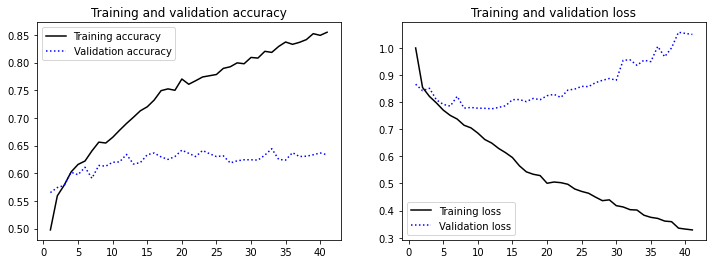

In [28]:
### Accuracy and loss plots ### 

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

epochs = [n + 1 for n in range(len(acc))]
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'k', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss, 'k', label='Training loss')
plt.plot(epochs, val_loss, 'b:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
model.save("MobileNet_finetuned.hd")

In [30]:
import shutil
shutil.rmtree("./miniddsm2")